# Create classification model(s)
- start with the "food.csv"
- tfidf vectorizer & classification models
- combining text fields except for "food_group" and/or "food_subgroup"

In [2]:
import pprint
import importlib
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

import modeling

In [37]:
importlib.reload(modeling);

#### pull data & basic cleanup
- get rid of columns that I won"t use
- remove the 47 rows that are missing "description" data

In [2]:
food = pd.read_csv("data/foodb_2020_04_07_csv/Food.csv")
food.head(3)

,id,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,...,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
0,1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,NaN,Angelica,1.jpg,image/jpeg,111325.0,2012-04-20 09:29:57 UTC,...,Type 1,2011-02-09 00:37:14 UTC,2019-05-14 18:04:13 UTC,NaN,2.0,False,specific,357850.0,True,FOOD00001
1,2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,NaN,Savoy cabbage,2.jpg,image/jpeg,155178.0,2012-04-20 09:39:54 UTC,...,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,NaN,NaN,False,specific,1216010.0,True,FOOD00002
2,3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,845789.0,Tilia tomentosa,3.jpg,image/jpeg,56367.0,2012-04-20 09:41:25 UTC,...,Type 1,2011-02-09 00:37:15 UTC,2019-05-17 16:19:45 UTC,NaN,NaN,False,specific,NaN,True,FOOD00003


In [3]:
rows = food.shape[0]
print(f"rows: {rows}")
print(f"columns: {food.columns}")

rows: 992
columns: Index(['id', 'name', 'name_scientific', 'description', 'itis_id',
       'wikipedia_id', 'picture_file_name', 'picture_content_type',
       'picture_file_size', 'picture_updated_at', 'legacy_id', 'food_group',
       'food_subgroup', 'food_type', 'created_at', 'updated_at', 'creator_id',
       'updater_id', 'export_to_afcdb', 'category', 'ncbi_taxonomy_id',
       'export_to_foodb', 'public_id'],
      dtype='object')


In [4]:
# getting rid of columns I don"t care about
drop_columns = ["itis_id", "picture_file_name", "picture_content_type", "picture_file_size", "picture_updated_at", "legacy_id", "created_at", "updated_at", "creator_id",
       "updater_id", "export_to_afcdb", "category", "ncbi_taxonomy_id", "export_to_foodb", "public_id", "food_type"]

print(f"keeping columns: {set(food.columns).difference(set(drop_columns))}")

keeping columns: {'id', 'food_subgroup', 'name_scientific', 'food_group', 'description', 'wikipedia_id', 'name'}


In [5]:
food.drop(columns=drop_columns, inplace=True)
food.head(3)

,id,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
0,1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs
1,2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages
2,3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs


In [6]:
null_count = {}
for col in food.columns:
    null_count[col] = round(food[col].isna().sum()/rows, 4)
    
null_count

{'id': 0.0,
 'name': 0.0,
 'name_scientific': 0.3196,
 'description': 0.0474,
 'wikipedia_id': 0.1401,
 'food_group': 0.003,
 'food_subgroup': 0.0071}

In [7]:
food.dropna(subset=["description"], inplace=True)
food.shape

(945, 7)

---
## EDA on "food_group" and "food_subgroup"

In [8]:
print(f"nulls in 'food_subgroup': {food['food_subgroup'].isna().sum()}")
print(f"nulls in 'food_group': {food['food_group'].isna().sum()}")

nulls in 'food_subgroup': 2
nulls in 'food_group': 2


In [9]:
food.dropna(subset=["food_group", "food_subgroup"], inplace=True)
food.shape

(943, 7)

In [10]:
food["food_group"].value_counts(normalize=True)

food_group
Aquatic foods                  0.179215
Fruits                         0.161188
Vegetables                     0.144221
Herbs and Spices               0.132556
Dishes                         0.049841
Cereals and cereal products    0.048780
Milk and milk products         0.038176
Beverages                      0.033934
Animal foods                   0.030753
Confectioneries                0.030753
Pulses                         0.029692
Nuts                           0.028632
Baking goods                   0.027572
Gourds                         0.020148
Soy                            0.007423
Teas                           0.007423
Snack foods                    0.007423
Fats and oils                  0.007423
Cocoa and cocoa products       0.006363
Coffee and coffee products     0.004242
Eggs                           0.002121
Baby foods                     0.001060
Herbs and spices               0.001060
Name: proportion, dtype: float64

In [1]:
food["food_group"].unique()

NameError: name 'food' is not defined

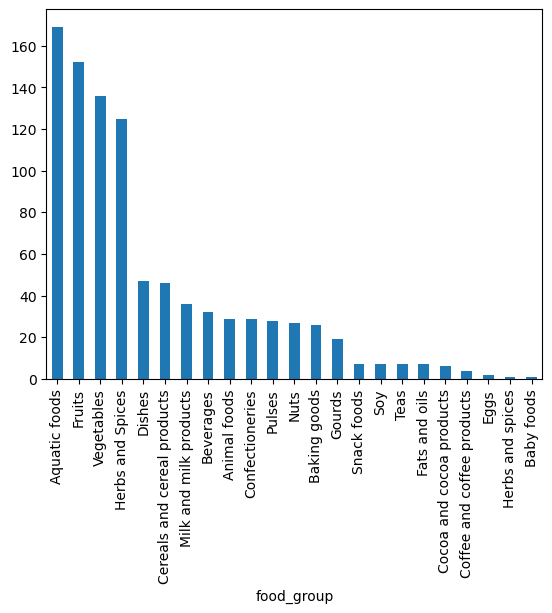

In [12]:
food.groupby("food_group").size().sort_values(ascending=False).plot(kind="bar");

In [13]:
food["food_group"] = food["food_group"].str.replace("Herbs and spices", "Herbs and Spices")
food["food_group"].unique()

array(['Herbs and Spices', 'Vegetables', 'Fruits', 'Nuts',
       'Cereals and cereal products', 'Pulses', 'Teas', 'Gourds',
       'Coffee and coffee products', 'Soy', 'Cocoa and cocoa products',
       'Beverages', 'Aquatic foods', 'Animal foods',
       'Milk and milk products', 'Eggs', 'Confectioneries',
       'Baking goods', 'Dishes', 'Snack foods', 'Baby foods',
       'Fats and oils'], dtype=object)

In [14]:
# "Dishes"??? what kind of label is that
food.loc[food["food_group"] == "Dishes"].head(10)

,id,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
636,655,Pizza,NaN,Pizza is an oven-baked flat bread typically to...,Pizza,Dishes,Other dishes
651,671,Sausage,NaN,Sausage is a food usually made from ground mea...,Sausage,Dishes,Ground meat
652,672,Meatball,NaN,Meatball is made from an amount of ground meat...,Meatball,Dishes,Ground meat
654,674,Pate,NaN,Pâté is a mixture of ground meat and fat mince...,Pâté,Dishes,Ground meat
668,691,Dumpling,NaN,Dumplings are cooked balls of dough. They are ...,Dumpling,Dishes,Other dishes
669,692,Soup,NaN,Soup is a generally warm food that is made by ...,Soup,Dishes,Other dishes
703,728,Burrito,NaN,"A burrito, or taco de harina, is a type of Mex...",Burrito,Dishes,Tex-Mex cuisine
704,729,Hamburger,NaN,A hamburger (also called a hamburger sandwich ...,Hamburger,Dishes,Sandwiches
705,730,Baked beans,NaN,"Baked beans is a dish containing beans, someti...",Baked_beans,Dishes,Other dishes
706,731,Chili,NaN,Chili con carne (often known simply as chili) ...,Chili_con_carne,Dishes,Tex-Mex cuisine


In [15]:
food.loc[food["food_group"] == "Baby foods"].head()

,id,name,name_scientific,description,wikipedia_id,food_group,food_subgroup
667,690,Baby food,NaN,"Baby food is any soft, easily consumed food, o...",Baby food,Baby foods,Baby foods


In [16]:
len(food["food_group"].unique())

22

In [17]:
len(food["food_subgroup"].unique())

112

In [18]:
fishy = food.loc[food["food_group"] == "Aquatic foods"]
fishy["food_subgroup"].value_counts()

food_subgroup
Fishes                 112
Mollusks                18
Crustaceans             12
Seaweed                  9
Pinnipeds                6
Other aquatic foods      5
Cetaceans                3
Amphibians               1
Fish products            1
Roe                      1
Bivalvia                 1
Name: count, dtype: int64

---
## prepare data for modeling
- combine text columns, except for "food_group"

In [19]:
text_cols = list(food.columns)
text_cols.remove("food_group")
text_cols.remove("id")
text_cols

['name', 'name_scientific', 'description', 'wikipedia_id', 'food_subgroup']

In [20]:
food.fillna("", inplace=True)

food["all_text"] = food[text_cols].apply(" ".join, axis=1)
food["all_text"].head(3)

0    Angelica Angelica keiskei Angelica is a genus ...
1    Savoy cabbage Brassica oleracea var. sabauda S...
2    Silver linden Tilia argentea Tilia tomentosa (...
Name: all_text, dtype: object

---
### transform target
- there are 22 labels in the "food_group" column
- considering a few different ways to encode those labels:
    - label encoder: just assigns a numerical value to each label
    - one-hot encoder: sparse array of binary values -- can"t use this on a target
    - get_dummies: primary disadvantage of this option is that it doesn"t generate an encoder object with attributes -- can"t use this on a target
    - <s>target encoder: calculates the probability of each label occurring</s>
- since some of the labels have very few instances in the data, I"m using cross-validation to evaluate thse encoders rather than train/test split
- I read a bunch of articles about different ways to encode target variables. These are my primary sources for the encodings I"ve tried here:
    - [this one](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd) included label and one hot encoding
    - [this one](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64) covered target and one hot encoding 
    - [this one](https://vitalflux.com/one-hot-encoding-concepts-python-code-examples/) included a section about the pros & cons of using one hot encoding
    - [this one](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69) went into more detail about target encoding...and pretty much convinced me not to try it on the food table, given the infrequency of some of the labels. Might try it on the content table, depending on the distribution.
    - [this answer](https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki) on stack overflow on using sklearn"s OHE vs. `get_dummies`

In [21]:
label_encoder = LabelEncoder()
label_enc_y = label_encoder.fit_transform(food["food_group"])

In [22]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_x = tfidf.fit_transform(food["all_text"])

lr = LogisticRegression(max_iter=1000)
cross_val_score(lr, tfidf_x, label_enc_y, cv=5).mean()

0.6744455701902511

## build pipelines
### references for choosing these hyperparameter options:
- [svc](https://www.baeldung.com/cs/svm-multiclass-classification) kernel options

In [23]:
# now that I know my label_encoder works, defining params for the different models I want to try
pipe_params = {
    "tfidf__max_features": [None, 250, 300],
    "tfidf__min_df": [1, 0.01, 0.05],
    "tfidf__max_df": [1.0, 0.98, 0.95, 0.9],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "lr__solver": ["lbfgs", "liblinear"],
    "lr__C": [1.0, 0.1, 10],
    "multi__alpha": [1.0, 0.5],
    "rfc__n_estimators": [100, 50, 150],
    "rfc__max_depth": [None, 5, 10],
    "rfc__min_samples_split": [2, 5, 7],
    "rfc__min_samples_leaf": [1, 2, 3],
    "rfc__bootstrap": [True, False],
    "knn__n_neighbors": range(1,11),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
    "svc__C": [1.0, 0.1, 10],
    "svc__kernel": ["poly", "rbf"],   
}

In [24]:
# and the components
vectorizer = ("tfidf", TfidfVectorizer(stop_words="english"))
lr_tuple = ("lr", LogisticRegression(max_iter=1000))
multi_tuple = ("multi", MultinomialNB())
rand_forest_tuple = ("rfc", RandomForestClassifier(n_jobs=-1))
knn_tuple = ("knn", KNeighborsClassifier())
svc_tuple = ("svc", SVC(random_state=42))

model_options = [lr_tuple, multi_tuple, rand_forest_tuple, knn_tuple, svc_tuple]

In [48]:
# this raises a warning on the "food" data:
# UserWarning: y_pred contains classes not in y_true - warnings.warn("y_pred contains classes not in y_true")
#  which makes sense because there are a couple of "food_group" labels with only 1 or 2 instances in that df

estimators = []
for model in model_options:
    pipe_components = [vectorizer, model]
    print(f"starting {model[0]} grid search")
    est = modeling.train_save_best_model(pipe=pipe_components, pipe_params=pipe_params, X_train=food["all_text"],
                                   y_train=label_enc_y, file_path=f"models/{model[0]}.pkl")
    estimators.append(est)

starting lr grid search
again!
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/heathercait/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: Use

KeyboardInterrupt: 

In [25]:
X = food["all_text"]
y = label_enc_y

pipeline_names = ["knn", "lr", "multi", "rfc", "svc"]

In [47]:
# use `fetch_fitted_pipeline` to fetch previously-fitted pipeline
scores = {}
for model_type in pipeline_names:
    gs = modeling.fetch_fitted_pipeline(f"models/{model_type}.pkl")
    gs.fit(X, y)
    scores[model_type] = gs.score(X, y)
    
scores

{'knn': 1.0,
 'lr': 0.9968186638388123,
 'multi': 0.8494167550371156,
 'rfc': 1.0,
 'svc': 1.0}

## combine content & food data

In [26]:
content = pd.read_csv("data/foodb_2020_04_07_csv/Content.csv")
content.columns

Index(['id', 'source_id', 'source_type', 'food_id', 'orig_food_id',
       'orig_food_common_name', 'orig_food_scientific_name', 'orig_food_part',
       'orig_source_id', 'orig_source_name', 'orig_content', 'orig_min',
       'orig_max', 'orig_unit', 'orig_citation', 'citation', 'citation_type',
       'creator_id', 'updater_id', 'created_at', 'updated_at', 'orig_method',
       'orig_unit_expression', 'standard_content', 'preparation_type',
       'export'],
      dtype='object')

In [27]:
content.head(10)

,id,source_id,source_type,food_id,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,...,citation_type,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export
0,1,1,Nutrient,4,29,Kiwi,Actinidia chinensis PLANCHON [Actinidiaceae],Fruit,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,1955.00,raw,0
1,2,1,Nutrient,6,53,Onion,Allium cepa L. [Liliaceae],Bulb,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,1853.95,raw,0
2,3,1,Nutrient,6,53,Onion,Allium cepa L. [Liliaceae],Leaf,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,4150.00,raw,0
3,4,1,Nutrient,9,55,Chives,Allium schoenoprasum L. [Liliaceae],Leaf,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,3900.00,raw,0
4,5,1,Nutrient,11,70,Cashew,Anacardium occidentale L. [Anacardiaceae],Fruit,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,2500.00,other,0
5,6,1,Nutrient,11,70,Cashew,Anacardium occidentale L. [Anacardiaceae],Leaf,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,1300.00,other,0
6,7,1,Nutrient,11,70,Cashew,Anacardium occidentale L. [Anacardiaceae],Seed,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,42600.00,other,0
7,8,1,Nutrient,12,74,Pineapple,Ananas comosus (L.) MERR. [Bromeliaceae],Fruit,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,2188.60,raw,0
8,9,1,Nutrient,13,83,Dill,Anethum graveolens L. [Apiaceae],Plant,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,4500.00,raw,0
9,10,1,Nutrient,13,83,Dill,Anethum graveolens L. [Apiaceae],Seed,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,12410.00,raw,0


In [28]:
content_drop_cols = ["id", "source_id", "source_type", "orig_content", "orig_min",
       "orig_max", "orig_unit", "orig_citation", "citation", "citation_type",
       "creator_id", "updater_id", "created_at", "updated_at", "orig_method",
       "orig_unit_expression", "standard_content", "preparation_type",
       "export"]

print(f"keeping columns: {set(content.columns).difference(set(content_drop_cols))}")

keeping columns: {'orig_food_common_name', 'orig_food_id', 'food_id', 'orig_source_name', 'orig_source_id', 'orig_food_part', 'orig_food_scientific_name'}


In [29]:
content.drop(content_drop_cols, axis=1, inplace=True)
content.isna().sum()

food_id                            0
orig_food_id                 4308143
orig_food_common_name         971656
orig_food_scientific_name    5099435
orig_food_part               5104956
orig_source_id               4448551
orig_source_name             4445227
dtype: int64

In [30]:
null_content = {}
content_rows = content.shape[0]
for col in content.columns:
    null_content[col] = round(content[col].isna().sum()/content_rows, 4)
    
null_content

{'food_id': 0.0,
 'orig_food_id': 0.8373,
 'orig_food_common_name': 0.1888,
 'orig_food_scientific_name': 0.991,
 'orig_food_part': 0.9921,
 'orig_source_id': 0.8645,
 'orig_source_name': 0.8639}

In [31]:
# pretty sure this is the column I care the most about so nulls here are no good to me
content.dropna(subset=["orig_food_common_name"], inplace=True)

In [32]:
big_food = content.merge(food, how="inner", left_on="food_id", right_on="id")
big_food.shape

(4074596, 15)

In [33]:
big_food.columns

Index(['food_id', 'orig_food_id', 'orig_food_common_name',
       'orig_food_scientific_name', 'orig_food_part', 'orig_source_id',
       'orig_source_name', 'id', 'name', 'name_scientific', 'description',
       'wikipedia_id', 'food_group', 'food_subgroup', 'all_text'],
      dtype='object')

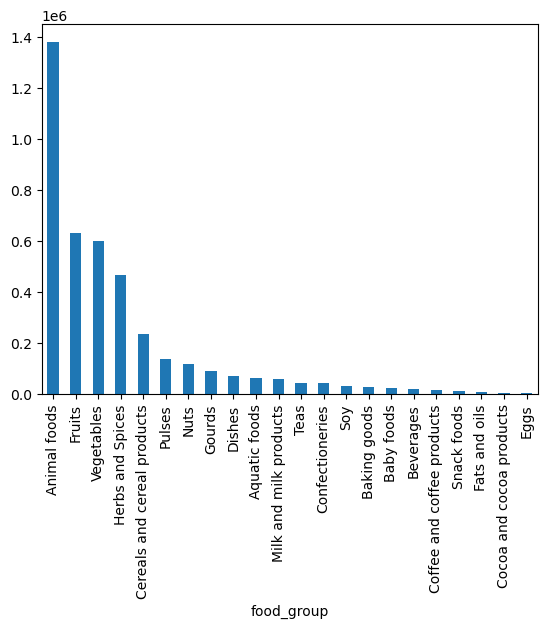

In [34]:
big_food.groupby("food_group").size().sort_values(ascending=False).plot(kind="bar");

In [77]:
big_food["food_group"].value_counts()

food_group
Animal foods                   1379454
Fruits                          631794
Vegetables                      598513
Herbs and Spices                465520
Cereals and cereal products     234181
Pulses                          135384
Nuts                            115887
Gourds                           91254
Dishes                           69061
Aquatic foods                    60628
Milk and milk products           59526
Teas                             43304
Confectioneries                  43204
Soy                              30632
Baking goods                     25452
Baby foods                       24071
Beverages                        19242
Coffee and coffee products       16119
Snack foods                      13467
Fats and oils                     6989
Cocoa and cocoa products          5473
Eggs                              5441
Name: count, dtype: int64

In [78]:
big_food.dtypes

food_id                       int64
orig_food_id                 object
orig_food_common_name        object
orig_food_scientific_name    object
orig_food_part               object
orig_source_id               object
orig_source_name             object
id                            int64
name                         object
name_scientific              object
description                  object
wikipedia_id                 object
food_group                   object
food_subgroup                object
all_text                     object
dtype: object

In [95]:
food["food_group"].value_counts().max()

169

In [92]:
# found this on https://linuxhint.com/pandas-get-most-frequent-value/
food["food_group"].value_counts().idxmax(skipna=True)

'Aquatic foods'

In [93]:
big_food.columns

Index(['food_id', 'orig_food_id', 'orig_food_common_name',
       'orig_food_scientific_name', 'orig_food_part', 'orig_source_id',
       'orig_source_name', 'id', 'name', 'name_scientific', 'description',
       'wikipedia_id', 'food_group', 'food_subgroup', 'all_text'],
      dtype='object')

In [100]:
cols_from_content = ["orig_food_id", "orig_food_common_name", "orig_food_scientific_name", 
                   "orig_food_part", "orig_source_id", "orig_source_name"]
merged_rows = big_food.shape[0]
table_data = {}
for col in cols_from_content:
    details = {}
    nulls = big_food[col].isna().sum()
    unique_vals = len(big_food[col].unique())
    details["null_count"] = nulls
    details["non_null_count"] = merged_rows-nulls
    details["unique_values"] = unique_vals
    details["most_common_value"] = big_food[col].value_counts().idxmax(skipna=True)
    details["most_common_value_occurances"] = big_food[col].value_counts().max()
    table_data[col] = details
    
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(table_data)

{ 'orig_food_common_name': { 'most_common_value': 'Lipid from Arabidopsis '
                                                  '(PathBank)',
                             'most_common_value_occurances': 1975575,
                             'non_null_count': 4074596,
                             'null_count': 0,
                             'unique_values': 9130},
  'orig_food_id': { 'most_common_value': 'WI4600',
                    'most_common_value_occurances': 7574,
                    'non_null_count': 805873,
                    'null_count': 3268723,
                    'unique_values': 11663},
  'orig_food_part': { 'most_common_value': 'Leaf',
                      'most_common_value_occurances': 8026,
                      'non_null_count': 40325,
                      'null_count': 4034271,
                      'unique_values': 79},
  'orig_food_scientific_name': { 'most_common_value': 'Camellia sinensis (L.) '
                                                      'KUNTZE [Th

In [35]:
# seems like there might be good text in these columns to add to the text I already have from food.csv
more_text_columns = ["orig_food_common_name", "orig_food_part", "orig_food_scientific_name", 
                     "orig_source_name", "all_text"]

for col in more_text_columns:
    big_food[col].fillna("", inplace=True)

In [36]:
big_food["all_text"] = big_food[more_text_columns].apply(" ".join, axis=1)

In [37]:
big_food["all_text"].head(3)

0    Kiwi Fruit Actinidia chinensis PLANCHON [Actin...
1    Kiwi fruit, raw   Protein, total Kiwi Actinidi...
2    Kiwi fruit, raw   Protein, total-N Kiwi Actini...
Name: all_text, dtype: object

In [38]:
big_label_enc_y = label_encoder.fit_transform(big_food["food_group"])

In [39]:
big_estimators = []
for model in model_options:
    pipe_components = [vectorizer, model]
    print(f"starting {model[0]} grid search")
    est = modeling.train_save_best_model(pipe=pipe_components, pipe_params=pipe_params, X_train=big_food["all_text"],
                                   y_train=big_label_enc_y, file_path=f"models/big_{model[0]}.pkl")
    big_estimators.append(est)

starting lr grid search
again!
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


---
## rabbit holes
- stuff I tried that didn"t go anywhere

---
- wouldn"t it be cool if I could do the transformations of both the data & the target in a pipeline?
- sadly, this did not work; I tried:
    - passing the whole df to `test_pipe.fit`, without doing a train/test split
    - passing the columns, no train/test split
    - doing the train/test split & passing `X_train` and `y_train`

In [ ]:
# inspired by this article: https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6

data_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(stop_words="english"))
])

# I don"t think this would have worked with the LabelEncoder either
# if I have time, I"ll come back & try that because it WOULD be cool if this worked
target_transformer = Pipeline(steps=[
    ("ord_encoder", OrdinalEncoder(categories=food["food_group"].unique())) 
])

preprocessor = ColumnTransformer(transformers=[
    ("data", data_transformer, "all_text"),
    ("target", target_transformer, "food_group")
])

test_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000))
])

In [ ]:
X = food.drop(columns=["food_group"])
y = food["food_group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# lr_model = test_pipe.fit(X_train, y_train)